In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline

In [12]:
class DeepMLP:
    def __init__(self, n_layers,n_features, n_neurons, learning_rate, epsilon, n_iter):
        """MLP with n hidden layer and n_neurons neurons in each hidden layer
        problem: binary classification
        """
        self.n_layers = n_layers        
        self.n_features = n_features
        self.n_neurons = n_neurons
        self.n_samples = None
        self.learning_rate = learning_rate
        self.tolerance = epsilon
        self.n_iter = n_iter
        self.loss = []

        #initialize weights and biases in each layer
        self.W = {}
        self.b = {}
        #input layer
        self.W[1] = np.random.randn(self.n_neurons, self.n_features)
        self.b[1] = np.random.randn(self.n_neurons, 1)
        #hidden layers
        for i in range(2, self.n_layers):
            self.W[i] = np.random.randn(self.n_neurons, self.n_neurons)
            self.b[i] = np.random.randn(self.n_neurons, 1)
        #output layer
        self.W[self.n_layers] = np.random.randn(1, self.n_neurons)
        self.b[self.n_layers] = np.random.randn(1, 1)

        #initialize values of neurons in each layer
        self.H = {}
        self.Out = {}
        self.Out_last = None
        
    relu = lambda self, x: np.maximum(0, x)
    
    sigmoid = lambda self, x: 1 / (1 + np.exp(-x))
    
    relu_derivative = lambda self, x: np.where(x > 0, 1, 0)
    
    sigmoid_derivative = lambda self, x: x * (1 - x)
    
    def forward(self, X):#shape_X = (n_features, n_samples)
        #forward propagation from input layer to the nearest hidden layer
        self.H[1] = np.dot(self.W[1], X) + self.b[1]
        self.Out[1] = self.relu(self.H[1])
        #foward propagation between hidden layers
        for i in range(2, self.n_layers):
            self.H[i] = np.dot(self.W[i], self.Out[i-1]) + self.b[i]
            self.Out[i] = self.relu(self.H[i])
        #forward propagation from the last hidden layer to the output layer
        self.H[self.n_layers] = np.dot(self.W[self.n_layers], self.Out[self.n_layers-1]) + self.b[self.n_layers]
        self.Out_last = self.sigmoid(self.H[self.n_layers])
        
    def cross_entropy(self, t):#shape_t= (1, n_samples)
        return np.sum(-t * np.log(self.Out_last) - (1 - t) * np.log(1 - self.Out_last))
    
    def backward(self, X, y, i):#shape_X = (n_features, n_samples), shape_y = (1, n_samples)
        dE_dW = {}#partial derivative of E with respect to each weight
        db_dW = {}#partial derivative of E with respect to each bias
        dH = {}#partial derivative of E with respect to each neuron
        dOut = {}#partial derivative of E with respect to each output
        dH[self.n_layers] = self.Out_last - y
        dE_dW[self.n_layers] = np.dot(dH[self.n_layers], self.Out[self.n_layers-1].T) / self.n_samples
        db_dW[self.n_layers] = np.mean(dH[self.n_layers], axis = 1, keepdims = True)
        for i in range(self.n_layers-1, 1, -1):
            dOut[i] = np.dot(self.W[i+1].T, dH[i+1])
            dH[i] = dOut[i] * self.relu_derivative(self.H[i])
            dE_dW[i] = np.dot(dH[i], self.Out[i-1].T) / self.n_samples
            db_dW[i] = np.mean(dH[i], axis = 1, keepdims = True)
        dOut[1] = np.dot(self.W[2].T, dH[2])
        dH[1] = dOut[1] * self.relu_derivative(self.H[1])
        dE_dW[1] = np.dot(dH[1], X.T) / self.n_samples
        db_dW[1] = np.mean(dH[1], axis = 1, keepdims = True)
        for i in range(1, self.n_layers):
            self.W[i] -= self.learning_rate * dE_dW[i]
            self.b[i] -= self.learning_rate * db_dW[i]

    def train(self, X, y):
        self.n_samples = X.shape[1]
        for iter in range(self.n_iter):
            self.forward(X)
            self.backward(X, y, iter)
            loss = self.cross_entropy(y)
            self.loss.append(loss)
            if loss < self.tolerance:
                print("iter: ", iter, " loss: ", loss)
                break
    
    def predict(self, X):
        self.forward(X)
        return np.where(self.Out_last > 0.5, 1, 0)    

In [16]:
# evaluate model
def evaluate(model, X, y):
    y_predict = model.predict(X)
    #calculate recall, precision and f1 score
    TP = np.sum(np.logical_and(y_predict == 1, y == 1))
    FP = np.sum(np.logical_and(y_predict == 1, y == 0))
    FN = np.sum(np.logical_and(y_predict == 0, y == 1))
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * precision * recall / (precision + recall)
    print('recall: {:.3f}, precision: {:.3f}, f1_score: {:.3f}'.format(recall, precision, f1_score))

#plot decision boundary
def plot_decision_boundary(model, X, y):
    #set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    #generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    #plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('decision boundary')
    plt.show()

#analyze loss
def plot_loss(model):
    plt.plot(model.loss)
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.title('loss')
    plt.show()

/tmp/ipykernel_979/2465616310.py:55: RuntimeWarning: divide by zero encountered in log
  return np.sum(-t * np.log(self.Out_last) - (1 - t) * np.log(1 - self.Out_last))
/tmp/ipykernel_979/2465616310.py:55: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-t * np.log(self.Out_last) - (1 - t) * np.log(1 - self.Out_last))


recall: 0.998, precision: 1.000, f1_score: 0.999


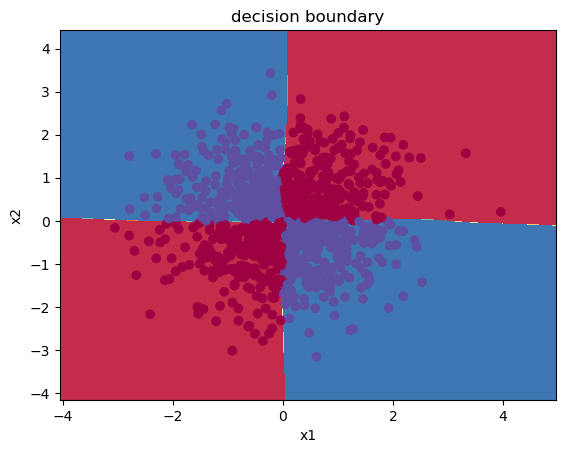

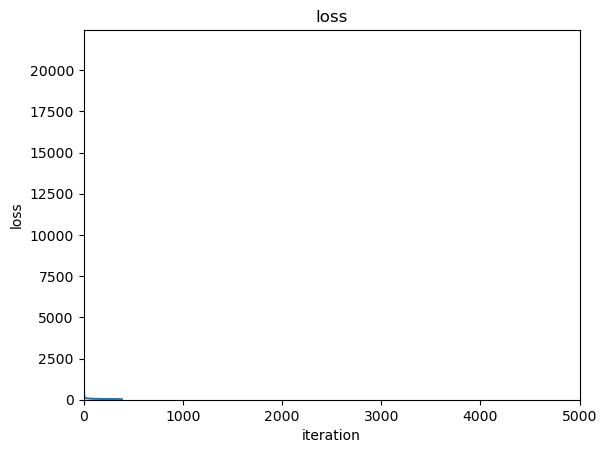

In [14]:
#test 1:
#generate data
np.random.seed(1)
X = np.random.randn(2, 1000)
y = np.logical_xor(X[0, :] > 0, X[1, :] > 0)
y = np.where(y == True, 1, 0)
#train model
model = DeepMLP(n_layers=4, n_features=2, n_neurons=15, learning_rate=0.1, epsilon=1e-5, n_iter=5000)
model.train(X, y)
#evaluate model
evaluate(model, X, y)
plot_decision_boundary(model, X, y)
plot_loss(model)

/tmp/ipykernel_979/2465616310.py:55: RuntimeWarning: divide by zero encountered in log
  return np.sum(-t * np.log(self.Out_last) - (1 - t) * np.log(1 - self.Out_last))
/tmp/ipykernel_979/2465616310.py:55: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-t * np.log(self.Out_last) - (1 - t) * np.log(1 - self.Out_last))


recall: 0.998, precision: 1.000, f1_score: 0.999


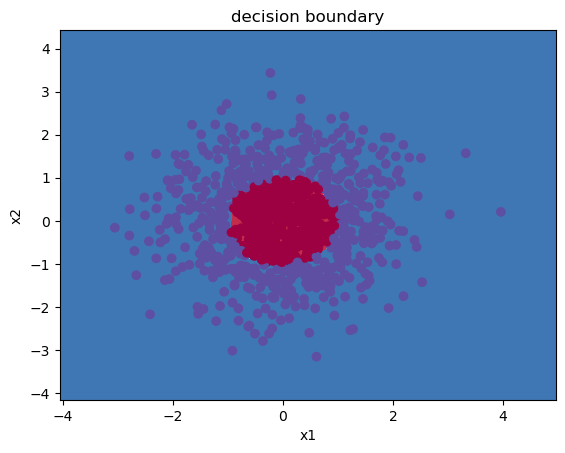

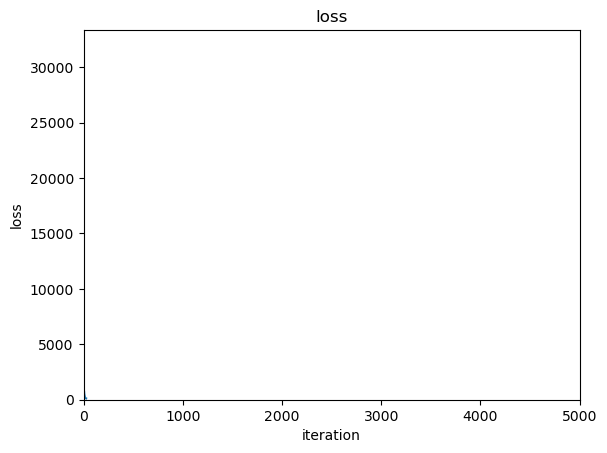

In [15]:
#test 2:
#generate data
np.random.seed(1)
X = np.random.randn(2, 1000)
y = np.array([0 if x[0]**2 + x[1]**2 < 1 else 1 for x in X.T]).reshape(1, -1)
#train model
model2 = DeepMLP(n_layers=4, n_features=2, n_neurons=15, learning_rate=0.1, epsilon=1e-5, n_iter=5000)
model2.train(X, y)
#evaluate model
evaluate(model2, X, y)
plot_decision_boundary(model2, X, y)
plot_loss(model2)

iter:  54  loss:  -0.42603136224223404
recall: 1.000, precision: 1.000, f1_score: 1.000


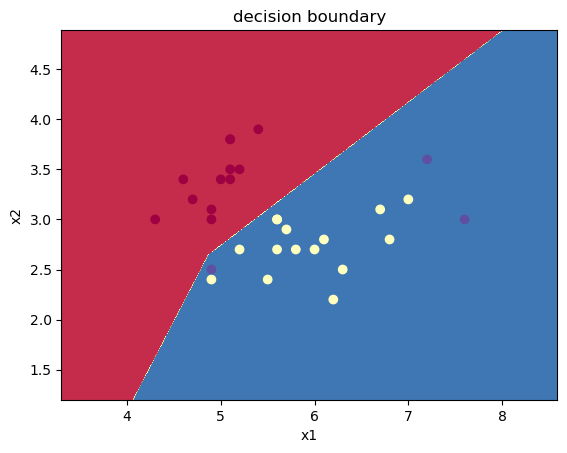

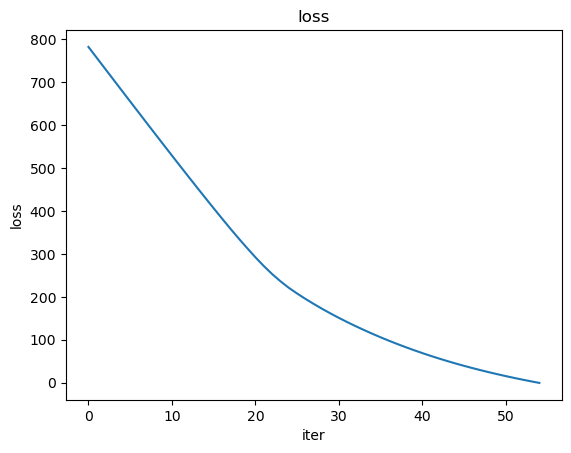

In [46]:
#test 3:
#get data and split into train and test sets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#train model
model3 = DeepMLP(n_layers=2, n_features=2, n_neurons=8, learning_rate=1e-3, epsilon=1e-6, n_iter=3000)
model3.train(X_train.T, y_train.reshape(1, -1))
#evaluate model
evaluate(model3, X_test.T, y_test.reshape(1, -1))
plot_decision_boundary(model3, X_test.T, y_test.reshape(1, -1))
plot_loss(model3)

In [44]:
#test 4:
#get data and split into train and test sets
data = datasets.make_moons(n_samples=1000, noise=0.2)
X = data[0].T
y = data[1].reshape(1, -1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#train model
model4 = DeepMLP(n_layers=3, n_features=2, n_neurons=15, learning_rate=1e-3, epsilon=1e-6, n_iter=3000)
model4.train(X_train, y_train)
#evaluate model
evaluate(model4, X_test, y_test)
plot_decision_boundary(model4, X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 1]